# 陈天奇的  XGBoost


In [11]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import datetime

from xgboost import XGBClassifier 


## 回归

In [113]:
#xgb实现法
import xgboost as xgb


data = load_boston()
X = data.data
y = data.target

Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.1,random_state=420)

#使用类DMatrix读取数据
dtrain = xgb.DMatrix( Xtrain,Ytrain ) #特征矩阵和标签都进行一个传入
dtest = xgb.DMatrix( Xtest,Ytest )



In [117]:
X.shape

(506, 13)

In [114]:

import pandas as pd

pd.DataFrame(Xtrain)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.10612,30.0,4.93,0.0,0.428,6.095,65.1,6.3361,6.0,300.0,16.6,394.62,12.40
1,0.62976,0.0,8.14,0.0,0.538,5.949,61.8,4.7075,4.0,307.0,21.0,396.90,8.26
2,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92
3,0.62356,0.0,6.20,1.0,0.507,6.879,77.7,3.2721,8.0,307.0,17.4,390.39,9.93
4,0.11329,30.0,4.93,0.0,0.428,6.897,54.3,6.3361,6.0,300.0,16.6,391.25,11.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.03871,52.5,5.32,0.0,0.405,6.209,31.3,7.3172,6.0,293.0,16.6,396.90,7.14
451,0.12650,25.0,5.13,0.0,0.453,6.762,43.4,7.9809,8.0,284.0,19.7,395.58,9.50
452,6.96215,0.0,18.10,0.0,0.700,5.713,97.0,1.9265,24.0,666.0,20.2,394.43,17.11
453,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,390.91,5.52


In [115]:
#写明参数
param = {
          'objective':'reg:squarederror'
         ,"eta":0.1}
num_round = 250 #n_estimators

#类train，可以直接导入的参数是训练数据，树的数量，其他参数都需要通过params来导入
bst = xgb.train(param, dtrain, num_round)

#接口predict
preds = bst.predict(dtest)

MSE(Ytest,preds)


5.381799034544578

## 多分类

In [2]:
def loadData( fileName, n=1000):
        '''
        加载文件

        :param fileName:要加载的文件路径
        :param n: 返回的数据集的规模
        :return: 数据集和标签集
        '''
        # 存放数据及标记
        dataArr = []
        labelArr = []
        # 读取文件
        fr = open(fileName)

        cnt = 0  # 计数器

        # 遍历文件中的每一行
        for line in fr.readlines():


            if cnt == n:
                break

            # 获取当前行，并按“，”切割成字段放入列表中
            # strip：去掉每行字符串首尾指定的字符（默认空格或换行符）
            # split：按照指定的字符将字符串切割成每个字段，返回列表形式
            curLine = line.strip().split(',')
            # 将每行中除标记外的数据放入数据集中（curLine[0]为标记信息）
            # 在放入的同时将原先字符串形式的数据转换为整型
            # 此外将数据进行了二值化处理，大于128的转换成1，小于的转换成0，方便后续计算
            dataArr.append([int(int(num) > 128) for num in curLine[1:]])

            # 将标记信息放入标记集中
            labelArr.append(int(curLine[0]))
            cnt += 1

        fr.close()

        # 返回数据集和标记
        return dataArr, labelArr

    
    


### sklearn 的 xgboost 接口

In [22]:
n_train=60000
n_test=10000

# 获取训练集
trainDataList, trainLabelList = loadData('../Mnist/mnist_train.csv', n=n_train)

print('train data, row num:{} , column num:{} '.format(len(trainDataList), len(trainDataList[0])))

trainDataArr = np.array(trainDataList)
trainLabelArr = np.array(trainLabelList)

# 开始时间
print('start training model....')
start = time.time()


"""

XGBClassifier 测试1:
max_depth=3, n_estimators=20, learning_rate=0.5, 
n_train=60000
n_test=10000
训练时间 : 38 s
准确率: 0.9155

"""


clf = XGBClassifier(
    max_depth=3, #
    learning_rate=0.5, # 学习率 eta 
    n_estimators=20, # 使用多少个弱分类器
    
    eval_metric='mlogloss',
    
    num_class=10,
   
    gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
    min_child_weight=1,
    max_delta_step=0,
    subsample=1, # 随机抽样的时候抽取的样本比例, 范围 (0,1]
    colsample_bytree=1,
    reg_alpha=0, # L1 正则化的强度
    reg_lambda=1, # L2 正则化的强度
    use_label_encoder=False
)

clf.fit(trainDataArr, trainLabelArr)


# 结束时间
end = time.time()
print('training cost time :', end - start)

# 获取测试集
testDataList, testLabelList = loadData('../Mnist/mnist_test.csv', n=n_test)

print('test data, row num:{} , column num:{} '.format(len(testDataList), len(testDataList[0])))

testDataArr = np.array(testDataList)
testLabelArr = np.array(testLabelList)

print('test dataset accuracy: {} '.format(clf.score(testDataArr, testLabelArr)))

train data, row num:60000 , column num:784 
start training model....


'\n\nXGBClassifier 测试1:\nmax_depth=3, n_estimators=20, learning_rate=0.5, \nn_train=60000\nn_test=10000\n训练时间 : 38 s\n准确率: 0.9155\n\n'

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=8,
              num_class=10, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

training cost time : 39.36630845069885
test data, row num:10000 , column num:784 
test dataset accuracy: 0.9155 


#### 学习曲线

In [28]:
n_train=6000
n_test=1000

# 获取训练集
trainDataList, trainLabelList = loadData('../Mnist/mnist_train.csv', n=n_train)

trainDataArr = np.array(trainDataList)
trainLabelArr = np.array(trainLabelList)

Xtrain,Ytrain = trainDataArr, trainLabelArr 


# 获取测试集
testDataList, testLabelList = loadData('../Mnist/mnist_test.csv', n=n_test)

print('test data, row num:{} , column num:{} '.format(len(testDataList), len(testDataList[0])))

testDataArr = np.array(testDataList)
testLabelArr = np.array(testLabelList)

Xtest,Ytest = testDataArr, testLabelArr 



test data, row num:1000 , column num:784 


In [15]:
def plot_learning_curve(estimator,title, X, y, 
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                       ):
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            ,random_state=420
                                                            ,n_jobs=n_jobs)      
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    ax.legend(loc="best")
    return ax


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'XGBoost'}, xlabel='Training examples', ylabel='Score'>

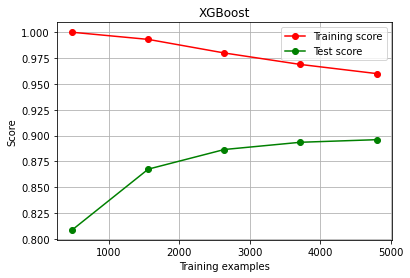

In [17]:
clf = XGBClassifier(
    max_depth=3, #
    learning_rate=0.5, # 学习率 eta 
    n_estimators=20, # 使用多少个弱分类器
    
    eval_metric='mlogloss',
    
    num_class=10,
   
    gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
    min_child_weight=1,
    max_delta_step=0,
    subsample=1, # 随机抽样的时候抽取的样本比例, 范围 (0,1]
    colsample_bytree=1,
    reg_alpha=0, # L1 正则化的强度
    reg_lambda=1, # L2 正则化的强度
    use_label_encoder=False
)

plot_learning_curve(clf
                    ,"XGBoost",Xtrain,Ytrain,ax=None,cv=5)
plt.show()

#### 参数调优 - 交叉验证

90 0.932


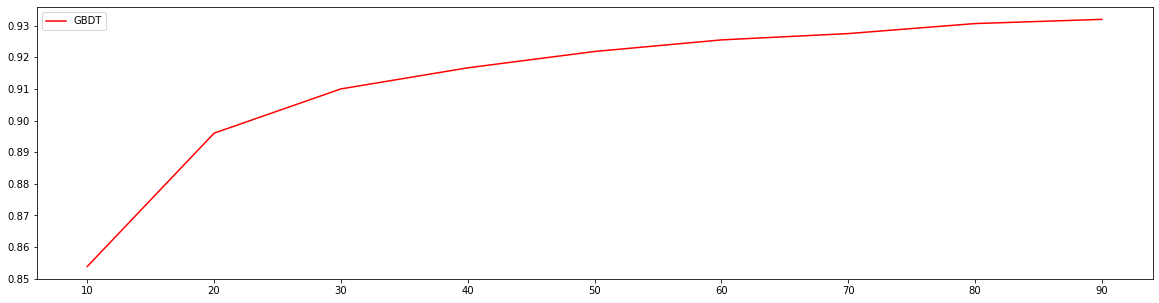

Wall time: 6min 1s


In [24]:
%%time 

# 超参数 n_estimators 调优
#=====【TIME WARNING： 6min 】=====#

axisx = range(10,100,10)
rs = []
for i in axisx:
    
    clf = XGBClassifier(
        max_depth=3, #
        learning_rate=0.5, # 学习率 eta 
        n_estimators=i, # 使用多少个弱分类器

        eval_metric='mlogloss',

        num_class=10,

        gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
        min_child_weight=1,
        max_delta_step=0,
        subsample=1, # 有放回的随机抽样 的时候抽取的样本比例, 范围 (0,1]
        colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
        reg_alpha=0, # L1 正则化的强度
        reg_lambda=1, # L2 正则化的强度
        
        use_label_encoder=False
    )
    
    rs.append( CVS( clf , Xtrain, Ytrain, cv=5 , n_jobs=-1).mean() ) #  n_jobs=-1 开启所有的 CPU 核
    
print( axisx[rs.index(max(rs))], max(rs) ) # n_estimators=90   accuracy= 0.932

plt.figure(figsize=(20,5))
plt.plot( axisx,rs,c="red",label="XGBoost" )
plt.legend()
plt.show()

0.4 0.9335000000000001


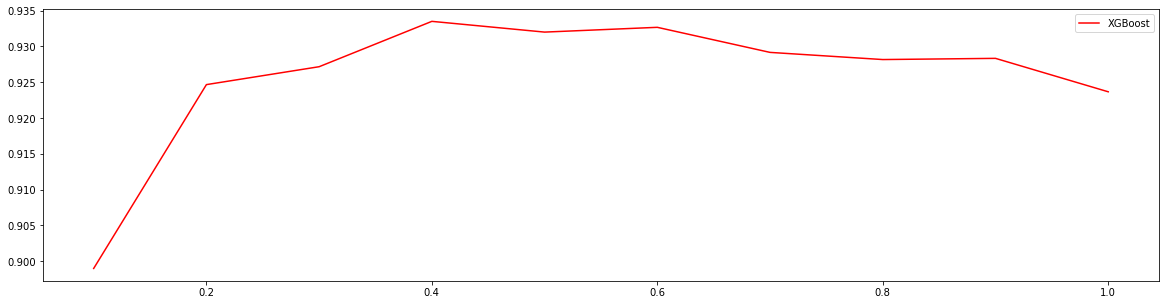

Wall time: 12min 8s


In [26]:
%%time 

# 超参数 learning_rate 调优
#=====【TIME WARNING：12min  】=====#


axisx = np.linspace(0.1,1,10)
rs = []
for i in axisx:
    
    clf = XGBClassifier(
        max_depth=3, #
        learning_rate=i, # 学习率 eta 
        n_estimators=90, # 使用多少个弱分类器

        eval_metric='mlogloss',

        num_class=10,

        gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
        min_child_weight=1,
        max_delta_step=0,
        subsample=1, # 有放回的随机抽样 的时候抽取的样本比例, 范围 (0,1]
        colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
        reg_alpha=0, # L1 正则化的强度
        reg_lambda=1, # L2 正则化的强度
        
        use_label_encoder=False
    )
    
    rs.append( CVS( clf,Xtrain,Ytrain,cv=5 ).mean() ) # 
    
    
print( "best param:{} , score:{}".format( axisx[rs.index(max(rs))], max(rs) )) # learning_rate=0.4 accuracy=0.9335000000000001

plt.figure(figsize=(20,5))
plt.plot( axisx,rs,c="red",label="XGBoost" )
plt.legend()
plt.show()

accuracy:0.93
accuracy:0.93
accuracy:0.93
accuracy:0.93
accuracy:0.93
0.625 0.9338333333333333


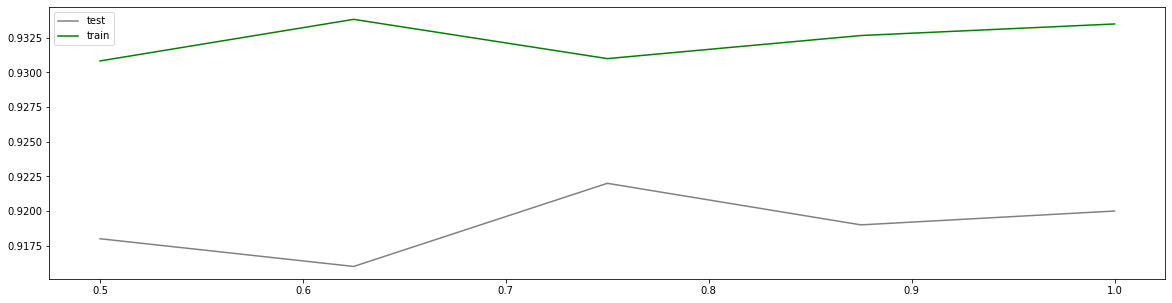

Wall time: 9min 25s


In [33]:
%%time 

# 超参数 subsample 调优

#=====【TIME WARNING：9 min 】=====#



#首先我们先来定义一个评分函数，这个评分函数能够帮助我们直接打印Xtrain上的交叉验证结果
def clfassess(clf,Xtrain,Ytrain,scoring = ["accuracy"],show=True):
    
    score = []
    for i in range(len(scoring)):
        
        c=CVS (clf,Xtrain,Ytrain,cv=5,scoring=scoring[i]).mean()
        
        if show:
            print("{}:{:.2f}".format(scoring[i] #模型评估指标的名字
                                ,c))
            
        score.append((c).mean())
        
    return score

axisx = np.linspace(0.5,1,5)
rs = []
te = []
for i in axisx:
    
    clf = XGBClassifier(
        
        max_depth=3, #
        learning_rate=0.4, # 学习率 eta 
        n_estimators=90, # 使用多少个弱分类器

        eval_metric='mlogloss',

        num_class=10,

        gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
        min_child_weight=1,
        max_delta_step=0,
        
        subsample=i, # 有放回的随机抽样 的时候抽取的样本比例, 范围 (0,1]
        
        colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
        reg_alpha=0, # L1 正则化的强度
        reg_lambda=1, # L2 正则化的强度
        
        use_label_encoder=False
    )
    
    score = clfassess( clf, Xtrain, Ytrain, scoring = ["accuracy"], show=True)
    
    test = clf.fit( Xtrain,Ytrain ).score( Xtest, Ytest )
    
    rs.append(score[0])
    te.append(test)
    
     
print("best param:{} , score:{}".format(axisx[rs.index(max(rs))],max(rs))) # subsample=0.625 accuracy=0.9338

plt.figure(figsize=(20,5))

plt.plot(axisx,te,c="gray",label="test")
plt.plot(axisx,rs,c="green",label="train")
plt.legend()
plt.show()


In [45]:
# 查看测试集 上的混淆矩阵

from sklearn.metrics import confusion_matrix 

from sklearn.utils.class_weight import compute_sample_weight


y_pred= clf.predict( testDataArr )
y_true=testLabelArr


confusion_matrix(y_true, y_pred) # 

sw = compute_sample_weight(class_weight='balanced',y=y_true)

confusion_matrix(y_true, y_pred, sample_weight=sw)


array([[ 83,   0,   0,   0,   0,   1,   1,   0,   0,   0],
       [  0, 124,   0,   1,   0,   0,   1,   0,   0,   0],
       [  0,   1, 104,   1,   0,   0,   1,   3,   5,   1],
       [  0,   0,   1,  96,   0,   5,   1,   1,   2,   1],
       [  1,   0,   0,   0, 100,   0,   1,   1,   1,   6],
       [  0,   0,   0,   3,   1,  79,   0,   3,   1,   0],
       [  3,   0,   0,   0,   1,   1,  82,   0,   0,   0],
       [  0,   0,   2,   2,   2,   1,   0,  87,   1,   4],
       [  0,   0,   1,   4,   3,   2,   0,   2,  77,   0],
       [  0,   0,   0,   0,   2,   0,   0,   3,   1,  88]], dtype=int64)

array([[97.64705882,  0.        ,  0.        ,  0.        ,  0.        ,
         1.17647059,  1.17647059,  0.        ,  0.        ,  0.        ],
       [ 0.        , 98.41269841,  0.        ,  0.79365079,  0.        ,
         0.        ,  0.79365079,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.86206897, 89.65517241,  0.86206897,  0.        ,
         0.        ,  0.86206897,  2.5862069 ,  4.31034483,  0.86206897],
       [ 0.        ,  0.        ,  0.93457944, 89.71962617,  0.        ,
         4.6728972 ,  0.93457944,  0.93457944,  1.86915888,  0.93457944],
       [ 0.90909091,  0.        ,  0.        ,  0.        , 90.90909091,
         0.        ,  0.90909091,  0.90909091,  0.90909091,  5.45454545],
       [ 0.        ,  0.        ,  0.        ,  3.44827586,  1.14942529,
        90.8045977 ,  0.        ,  3.44827586,  1.14942529,  0.        ],
       [ 3.44827586,  0.        ,  0.        ,  0.        ,  1.14942529,
         1.14942529, 94.25287356,  0.        

#### 参数调优 - 网格搜索

In [27]:
#来查看一下sklearn中所有的 模型评估指标
import sklearn
sorted(sklearn.metrics.SCORERS.keys())


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

ref:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [37]:
from sklearn.model_selection import GridSearchCV


def print_best_score(gsearch,param_test):
     # 输出best score
    print("Best score: %0.3f" % gsearch.best_score_)
    print("Best parameters set:")
    # 输出最佳的分类器到底使用了怎样的参数
    best_parameters = gsearch.best_estimator_.get_params()
    for param_name in sorted(param_test.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

        


In [38]:

param = {
    'gamma':  [0,2,5],
    'max_depth': range(1,5,1)
}
#网格搜索 是 两个 参数集合的全组合(笛卡尔积), 因此 集合中的元素个数 不宜过多

estimator = XGBClassifier(
        
        max_depth=3, #
        learning_rate=0.4, # 学习率 eta 
        n_estimators=90, # 使用多少个弱分类器

        eval_metric='mlogloss',

        num_class=10,

        gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
        
        min_child_weight=1,
        max_delta_step=0,
        
        subsample=0.625, # 有放回的随机抽样, 抽取的样本比例, 范围 (0,1]
        
        colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
        reg_alpha=0, # L1 正则化的强度
        reg_lambda=1, # L2 正则化的强度
        
        use_label_encoder=False
    )

gsearch = GridSearchCV( estimator , param_grid = param, scoring='accuracy', cv=5 , n_jobs=-1 )

gsearch.fit( Xtrain,Ytrain )


print_best_score(gsearch,param)

# Best score: 0.937
# Best parameters set:
# 	gamma: 0
# 	max_depth: 4


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     eval_metric='mlogloss', gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.4, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=90, n_jobs=None, num_class=10,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=0.625,
                                     t

Best score: 0.937
Best parameters set:
	gamma: 0
	max_depth: 4


## 二分类

### xgboost 原生接口

In [46]:

def loadData_2classification( fileName, n=1000):
    '''
    加载文件

    将 数据集 的标签 转换为 二分类的标签

    :param fileName:要加载的文件路径
    :param n: 返回的数据集的规模
    :return: 数据集和标签集
    '''
    # 存放数据及标记
    dataArr = []
    labelArr = []
    # 读取文件
    fr = open(fileName)

    cnt = 0  # 计数器

    # 遍历文件中的每一行
    for line in fr.readlines():

        if cnt == n:
            break

        # 获取当前行，并按“，”切割成字段放入列表中
        # strip：去掉每行字符串首尾指定的字符（默认空格或换行符）
        # split：按照指定的字符将字符串切割成每个字段，返回列表形式
        curLine = line.strip().split(',')
        # 将每行中除标记外的数据放入数据集中（curLine[0]为标记信息）
        # 在放入的同时将原先字符串形式的数据转换为整型
        # 此外将数据进行了二值化处理，大于128的转换成1，小于的转换成0，方便后续计算
        dataArr.append([int(int(num) > 128) for num in curLine[1:]])

        # 将标记信息放入标记集中
        # 转换成二分类任务
        # 标签0设置为1，反之为0

        # 显然这会导致 正负 样本的 分布不均衡, 1 的样本很少(10%), 而0 的很多
        if int(curLine[0]) == 0:
            labelArr.append(1)
        else:
            labelArr.append(0)

        # if int(curLine[0]) <= 5:
        #     labelArr.append(1)
        # else:
        #     labelArr.append(0)

        cnt += 1

    fr.close()

    # 返回数据集和标记
    return dataArr, labelArr
    
    



In [47]:
n_train=6000

# 获取训练集
trainDataList, trainLabelList =loadData_2classification('../Mnist/mnist_train.csv', n=n_train)

print('train data, row num:{} , column num:{} '.format(len(trainDataList), len(trainDataList[0])))

trainDataArr = np.array(trainDataList)
trainLabelArr = np.array(trainLabelList)


n_test=1000

# 获取测试集
testDataList, testLabelList = loadData_2classification('../Mnist/mnist_test.csv', n=n_test)

print('test data, row num:{} , column num:{} '.format(len(testDataList), len(testDataList[0])))

testDataArr = np.array(testDataList)
testLabelArr = np.array(testLabelList)


train data, row num:6000 , column num:784 
test data, row num:1000 , column num:784 


In [48]:

import xgboost as xgb


#使用类DMatrix读取数据
dtrain = xgb.DMatrix( trainDataArr,trainLabelArr ) #特征矩阵和标签都进行一个传入
dtest = xgb.DMatrix( testDataArr,testLabelArr )


In [50]:
# 使用 pandas 查看样本

import pandas as pd

pd.DataFrame(trainDataArr)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
# estimator = XGBClassifier(
        
#         max_depth=3, #
#         learning_rate=0.4, # 学习率 eta 
#         n_estimators=90, # 使用多少个弱分类器
#         eval_metric='mlogloss',
#         num_class=10,
#         gamma=0, # 损失函数中 树的总叶子个数T 的系数, 可以控制模型的复杂度
#         min_child_weight=1,
#         max_delta_step=0,
#         subsample=0.625, # 有放回的随机抽样, 抽取的样本比例, 范围 (0,1]
#         colsample_bytree=1, # 构造 每棵树 随机抽样出的特征占总特征的比例
#         reg_alpha=0, # L1 正则化的强度
#         reg_lambda=1, # L2 正则化的强度
#         use_label_encoder=False
#     )


# param= {'silent':True,'objective':'binary:logistic',"eta":0.4}

param= {'eval_metric':'logloss',"eta":0.4,}


num_round = 90 #n_estimators

#类train，可以直接导入的参数是训练数据，树的数量，其他参数都需要通过params来导入
bst = xgb.train( param, dtrain, num_round )


In [66]:
from sklearn.metrics import confusion_matrix 
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score

from sklearn.metrics import recall_score

from sklearn.metrics import f1_score


y_pred =( bst.predict(dtest) > 0.5 ).astype(int) #  predict() 返回的是概率  

y_true= testLabelArr

# 1.正确率
print('test dataset accuracy: {} '.format(accuracy_score(y_true, y_pred)))

print('====================')

test dataset accuracy: 0.983 


#### 样本不均衡问题



In [72]:

print( '0 负样本所占的比例: {} '.format( len(trainLabelArr[trainLabelArr==0])/len(trainLabelArr) ))  



0 样本所占的比例: 0.9013333333333333 


In [80]:
from sklearn.metrics import confusion_matrix as cm, accuracy_score as accuracy ,recall_score as recall, roc_auc_score as auc


#写明参数
scale_pos_weight = [ 0.5 , 1 , 5 , 9 ,10]
names = [
    
         "negative vs positive: 0.5 ",
         "negative vs positive: 1",
         "negative vs positive: 5",
         "negative vs positive: 9",
         "negative vs positive: 10"
        
        ]


[*zip(names,scale_pos_weight)]


for name,i in zip(names,scale_pos_weight):
    
    param= { 'eval_metric':'logloss',"eta":0.4,"scale_pos_weight":i } # scale_pos_weight = 负样本 / 正样本
    
    num_round = 40
    
    clf = xgb.train(param, dtrain, num_round)
    
    preds = clf.predict(dtest)
    
    ypred = preds.copy()
    ypred[preds > 0.5] = 1
    ypred[ypred != 1] = 0
    
    print(name)
    
    print("\tAccuracy:{}".format(accuracy(testLabelArr,ypred)))
    print("\tRecall:{}".format(recall(testLabelArr,ypred)))
    print("\tAUC:{}".format(auc(testLabelArr,preds)))


[('negative vs positive: 0.5 ', 0.5),
 ('negative vs positive: 1', 1),
 ('negative vs positive: 5', 5),
 ('negative vs positive: 9', 9),
 ('negative vs positive: 10', 10)]

negative vs positive: 0.5 
	Accuracy:0.978
	Recall:0.8352941176470589
	AUC:0.98424943747991
negative vs positive: 1
	Accuracy:0.982
	Recall:0.8823529411764706
	AUC:0.992928318868531
negative vs positive: 5
	Accuracy:0.979
	Recall:0.9411764705882353
	AUC:0.9974927675988429
negative vs positive: 9
	Accuracy:0.981
	Recall:0.9529411764705882
	AUC:0.9954355512696882
negative vs positive: 10
	Accuracy:0.978
	Recall:0.9647058823529412
	AUC:0.997389906782385


#### 交叉验证

<Figure size 1440x360 with 0 Axes>

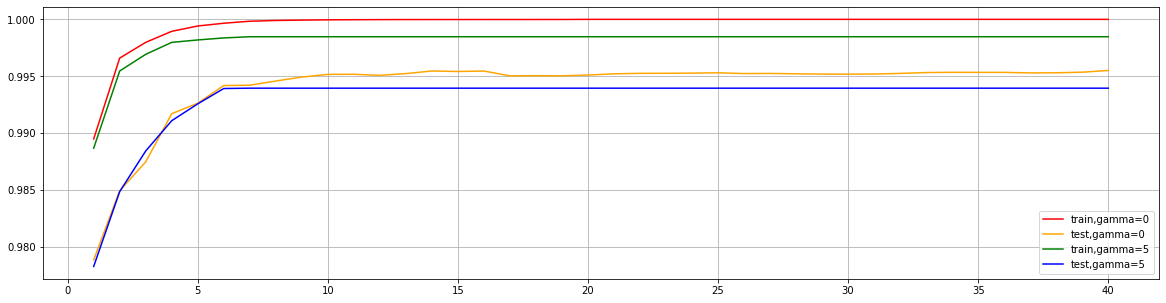

In [93]:
#设定参数
param1 = { 'eval_metric':'logloss',"eta":0.4,"scale_pos_weight":9 , "gamma":0 }
param2 = { 'eval_metric':'logloss',"eta":0.4,"scale_pos_weight":9 , "gamma":5 }

num_round = 40
n_fold=5 # sklearn - KFold


cvresult1 = xgb.cv(param1, dtrain, num_round ,n_fold ,  metrics='auc')


cvresult2 = xgb.cv(param2, dtrain, num_round ,n_fold ,  metrics='auc')

plt.figure(figsize=(20,5))
plt.grid()

plt.plot(range(1,41),cvresult1.iloc[:,0],c="red",label="train,gamma=0")
plt.plot(range(1,41),cvresult1.iloc[:,2],c="orange",label="test,gamma=0")
plt.plot(range(1,41),cvresult2.iloc[:,0],c="green",label="train,gamma=5")
plt.plot(range(1,41),cvresult2.iloc[:,2],c="blue",label="test,gamma=5")

plt.legend()
plt.show()


In [92]:
#看看类xgb.cv生成了什么结果？

cvresult1 


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.989501,1.186845e-03,0.978887,0.008674
1,0.996601,6.640182e-04,0.984962,0.009508
2,0.997981,4.934967e-04,0.987487,0.008546
3,0.998949,2.517591e-04,0.991722,0.005273
4,0.999417,1.153093e-04,0.992638,0.004984
5,0.999659,1.096394e-04,0.994191,0.003647
6,0.999837,5.086689e-05,0.994219,0.003631
7,0.999900,3.177798e-05,0.994590,0.003288
8,0.999934,3.166449e-05,0.994933,0.003211
9,0.999959,4.429718e-05,0.995169,0.003235


# 我的 xgboost

In [95]:
N=10 
np.transpose( [1] * N)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [112]:
a = np.array([ 0.375, 1.1 , 0.175, -0.225, -0.325])

np.sum(a, dtype=np.int32)


1

In [ ]:
def fit(self, X, y, sample_weight=None,X_idx_sorted=None):
        # 真正的fit（）函数
        self.X = X
        self.y = y

        random_state = check_random_state(self.random_state)

        #检查输入，包括数据集和标签
        X = check_array(X, dtype=DTYPE, accept_sparse="csc")
        y = check_array(y, ensure_2d=False, dtype=None)

        # 确定输出设置
        n_samples, self.n_features_ = X.shape#(150, 4)

        #self的这个--"_estimator_type"--属性哪里来的？
        is_classification = self.__getattribute__("_estimator_type") == "classifier"
        y = np.atleast_1d(y)#将输入转换为至少一维的数组

        expanded_class_weight = None

        #并不支持同时输入--多个标签（label），那么这里的意义是什么？
        if y.ndim == 1:#如果“类别”是一维（行向量、列表）--转为列向量
            y = np.reshape(y, (-1, 1))
        self.n_outputs_ = y.shape[1]#这里恒==1呀

        if is_classification:#如果是分类树
            y = np.copy(y)

            self.classes_ = []
            self.n_classes_ = []
            if self.class_weight is not None:
                y_original = np.copy(y)
            y_encoded = np.zeros(y.shape, dtype=np.int)

            #看这段代码是允许--多列的，但是 确实是不允许的呀。为什么？？？
            for k in range(self.n_outputs_):
                classes_k, y_encoded[:, k] = np.unique(y[:, k],return_inverse=True)
                #去重后元素组--##--对应位置元素在新组中下标
                self.classes_.append(classes_k)#类别--[0 , 1, 2]
                self.n_classes_.append(classes_k.shape[0])#类别数--3

            y = y_encoded#y存储的是--对应位置元素在--类别self.classes_--对应下标
            if self.class_weight is not None:
                expanded_class_weight = compute_sample_weight(
                    self.class_weight, y_original)

        else:
            self.classes_ = [None] * self.n_outputs_
            self.n_classes_ = [1] * self.n_outputs_
        self.n_classes_ = np.array(self.n_classes_, dtype=np.intp)#类别数==[3]

        #检查参数
        max_depth = ((2 ** 31) - 1 if self.max_depth is None else self.max_depth)
        max_leaf_nodes = (-1 if self.max_leaf_nodes is None else self.max_leaf_nodes)
        #(2 ** 31) - 1 --##-- -1

        #min_samples_leaf == 1
        if isinstance(self.min_samples_leaf, (numbers.Integral, np.integer)):
            min_samples_leaf = self.min_samples_leaf
        else:  # float，就是比例形式
            min_samples_leaf = int(ceil(self.min_samples_leaf * n_samples))

        #self.min_samples_split == 2 -- 允许进一步拆分的最小子样本数
        if isinstance(self.min_samples_split, (numbers.Integral, np.integer)):
            min_samples_split = self.min_samples_split
        else:  # float
            min_samples_split = int(ceil(self.min_samples_split * n_samples))
            min_samples_split = max(2, min_samples_split)
        #允许进一步拆分的最小子样本数
        #该参数--由自身 和 min_samples_leaf  共同决定（父子集太小--子子集也会很小）
        min_samples_split = max(min_samples_split, 2 * min_samples_leaf)
        if isinstance(self.max_features, six.string_types):
            if self.max_features == "auto":
                if is_classification:
                    max_features = max(1, int(np.sqrt(self.n_features_)))
                else:
                    max_features = self.n_features_
            elif self.max_features == "sqrt":
                max_features = max(1, int(np.sqrt(self.n_features_)))
            elif self.max_features == "log2":
                max_features = max(1, int(np.log2(self.n_features_)))

        elif self.max_features is None:
            max_features = self.n_features_
        elif isinstance(self.max_features, (numbers.Integral, np.integer)):
            max_features = self.max_features
        else:  # float
            if self.max_features > 0.0:
                max_features = max(1,int(self.max_features * self.n_features_))
            else:
                max_features = 0
        self.max_features_ = max_features
        #整个一大块就是为了确定 -- self.max_features_ -- 最终确定为 -- 4
        # Set min_weight_leaf from min_weight_fraction_leaf
        min_weight_leaf = (self.min_weight_fraction_leaf *n_samples)
        min_impurity_split = 1e-7
        #最重要部分###################################################
        # Build tree--终于开始构造--树！!!!!!!!!!!!!!!!!!!!
        criterion = self.criterion#gini
        #将--gini--转为--<sklearn.tree._criterion.Gini object at 0x7f9d4b441f50>
        if not isinstance(criterion, Criterion):
            if is_classification:
                criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,self.n_classes_)
            else:
                criterion = CRITERIA_REG[self.criterion](self.n_outputs_,n_samples)

        SPLITTERS = SPARSE_SPLITTERS if issparse(X) else DENSE_SPLITTERS
        #print(SPLITTERS)#{'random': <type 'sklearn.tree._splitter.RandomSplitter'>, 'best': <type 'sklearn.tree._splitter.BestSplitter'>}

        splitter = self.splitter#best
        if not isinstance(self.splitter, Splitter):
            splitter = SPLITTERS[self.splitter](criterion,
                                                self.max_features_,
                                                min_samples_leaf,
                                                min_weight_leaf,
                                                random_state,
                                                self.presort)

        #参数--(4, array([3]), 1)
        self.tree_ = Tree(self.n_features_, self.n_classes_, self.n_outputs_)

        # Use BestFirst if max_leaf_nodes given; use DepthFirst otherwise
        print(min_samples_leaf)
        if max_leaf_nodes < 0:
            #以深度优先的方式构建决策树

            # <sklearn.tree._splitter.BestSplitter object at 0x7f546bb3ae20>
            #由 特征选择方法criterion 和 特征划分点选择splitter 共同决定
            builder = DepthFirstTreeBuilder(splitter,
                                            min_samples_split,
                                            min_samples_leaf,
                                            min_weight_leaf,
                                            max_depth,
                                            self.min_impurity_decrease,
                                            min_impurity_split)
        else:
            builder = BestFirstTreeBuilder(splitter, min_samples_split,
                                           min_samples_leaf,
                                           min_weight_leaf,
                                           max_depth,
                                           max_leaf_nodes,
                                           self.min_impurity_decrease,
                                           min_impurity_split)

        builder.build(self.tree_, X, y, sample_weight, X_idx_sorted)
        #到这里树就构造完成了？？？--完全看不到过程

        if self.n_outputs_ == 1:
            self.n_classes_ = self.n_classes_[0]
            self.classes_ = self.classes_[0]
        #(3, array([0, 1, 2]))
        return self